In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib as jl
import itertools
import scipy.io as sio
import time

G = 6.67e-11

In [110]:
def cal_h(x, y, z, xi, eta, zeta):
    X = [xi - 0.5 * dx - x, xi + 0.5 * dx - x]
    Y = [eta - 0.5 * dy - y, eta + 0.5 * dy - y]
    Z = [zeta - 0.5 * dz - z, zeta + 0.5 * dz - z]

    h = 0

    for i in range(2):
        for j in range(2):
            for k in range(2):
                R = np.sqrt(X[i]**2 + Y[j]**2 + Z[k]**2)
                mu = (-1) ** (i + j + k + 3)
                tmp = G * mu * (
                    Z[k] * np.arctan(X[i] * Y[j] / Z[k] / R) -
                    X[i] * np.log(R + Y[j]) -
                    Y[j] * np.log(R + X[i])
                )
                h = h + tmp
    return h


In [111]:
def fast_forward():
    obs = np.zeros((nx, ny))
    with tqdm(total=nz) as tbar:
        for k in range(nz):
            t = np.zeros((2 * nx, 2 * ny))
            h = np.zeros((nx, ny))
            for i in range(nx):
                for j in range(ny):
                    h[i, j] = cal_h(XO[0], YO[0], zo, X[i], Y[j], Z[k])

            t[nx:, ny:] = h
            t[1:nx, ny:] = h[-1:0:-1, :]
            t[nx:, 1:ny] = h[:, -1:0:-1]
            t[1:nx, 1:ny] = h[-1:0:-1, -1:0:-1]

            c = np.zeros_like(t)
            c[:nx, :ny] = t[nx:, ny:]
            c[nx:, ny:] = t[:nx, :ny]
            c[:nx, ny:] = t[nx:, :ny]
            c[nx:, :ny] = t[:nx, ny:]

            g = np.zeros_like(c)
            g[:nx, :ny] = rho[:, :, k]

            cc = np.fft.fft2(c)
            gg = np.fft.fft2(g)
            ff = cc * gg
            f = np.fft.ifft2(ff)

            gz = np.abs(f[:nx, :ny])
            obs += gz
            tbar.update(1)
    return obs

In [112]:
def normal_forward():
    def forward_one(xo, yo):
        nonlocal pbar
        h = np.zeros((nx, ny, nz))
        for i, xi in enumerate(X):
            for j, eta in enumerate(Y):
                for k, zeta in enumerate(Z):
                    h[i, j, k] = cal_h(xo, yo, zo, xi, eta, zeta)
        pbar.update(1)
        return h

    obs = np.zeros((nx, ny))
    with tqdm(total=nx * ny) as pbar:
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                h = forward_one(x, y)
                obs[i, j] = np.sum(rho * h)
    return obs


def multi_normal_forward():
    obs = np.zeros((nx, ny))
    with tqdm(total = nx * ny) as pbar:
        for i, xo in enumerate(X):
            for j, yo in enumerate(Y):
                h = jl.Parallel(n_jobs=-1)([jl.delayed(cal_h)(xo, yo, zo, xi, eta, zeta) for xi, eta, zeta in itertools.product(X, Y, Z)])
                h = np.array(h).reshape((nx, ny, nz))
                pbar.update(1)
                obs[i, j] = np.sum(rho * h)
    return obs


In [113]:
nx = 16
ny = 16
nz = 8

xmax = 400
ymax = 400
zmax = 400

X = np.linspace(-xmax, xmax, nx)
Y = np.linspace(-ymax, ymax, ny)
Z = np.linspace(0, zmax, nz)

XO = np.linspace(-xmax, xmax, nx)
YO = np.linspace(-ymax, ymax, ny)

dx = X[1] - X[0]
dy = Y[1] - Y[0]
dz = Z[1] - Z[0]

zo = -5

rho = np.ones((nx, ny, nz))

XX, YY, ZZ = np.meshgrid(X, Y, Z)
rho[np.sqrt(XX**2 + YY**2 + (ZZ - 300)**2) <= 200] = 5

# rho[np.sqrt((XX - 400) ** 2 + (YY + 400) ** 2 + (ZZ - 100) ** 2) <= 100] = 5

In [105]:
obs_fast = fast_forward()
# obs_normal = normal_forward()
obs_normal = multi_normal_forward()

100%|██████████| 256/256 [00:16<00:00, 15.67it/s]


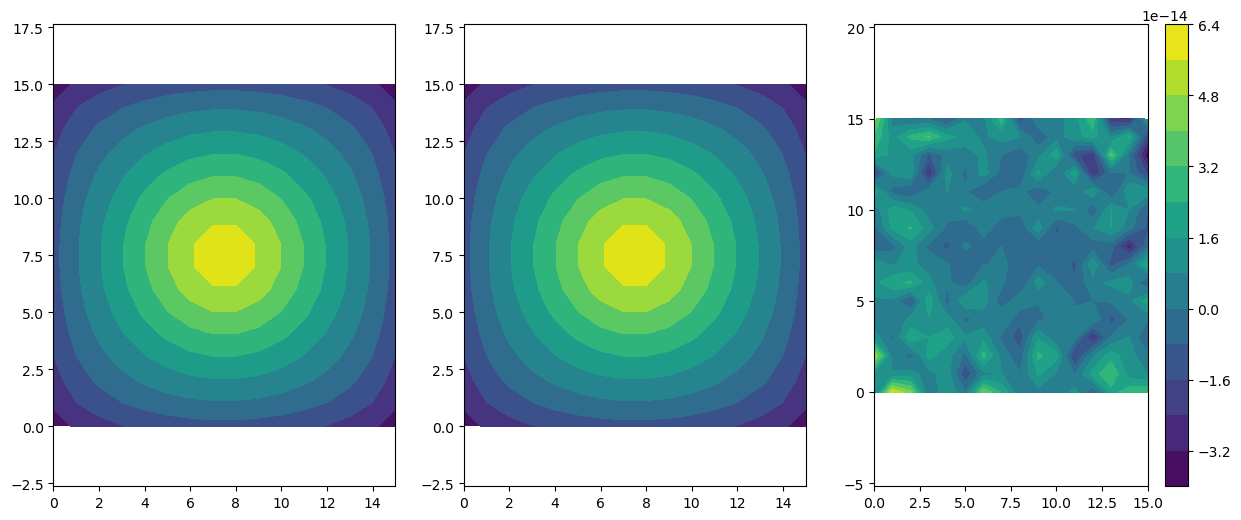

In [106]:
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.contourf(obs_normal, levels=12)
plt.axis('equal')

plt.subplot(132)
plt.contourf(obs_fast, levels=12)
plt.axis('equal')

plt.subplot(133)
plt.contourf((obs_normal - obs_fast) / obs_normal, levels=12)
plt.axis('equal')
plt.colorbar()
plt.show()

100%|██████████| 25/25 [00:00<00:00, 32.98it/s]


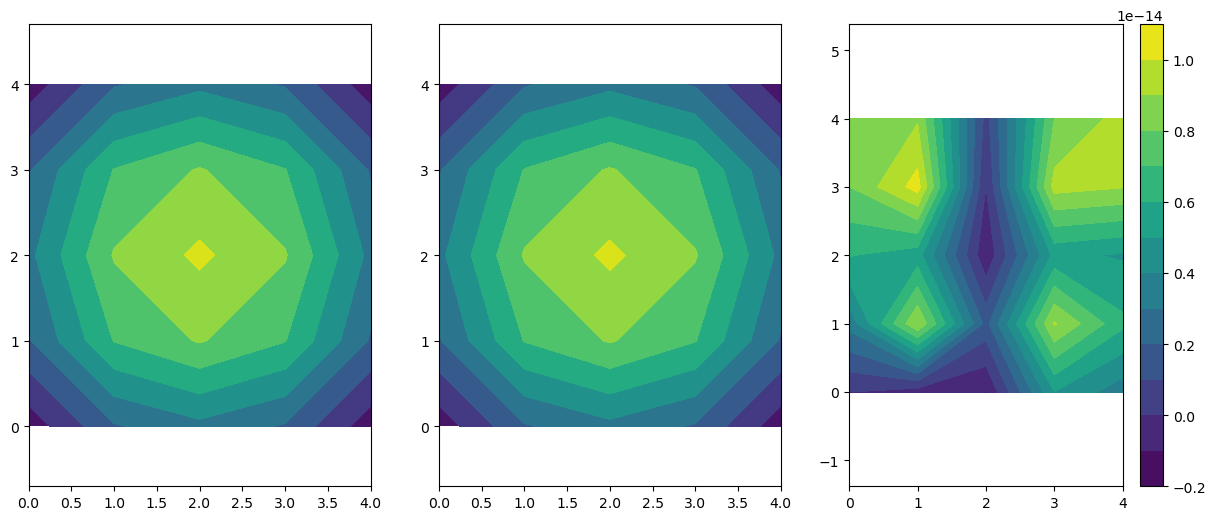

100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


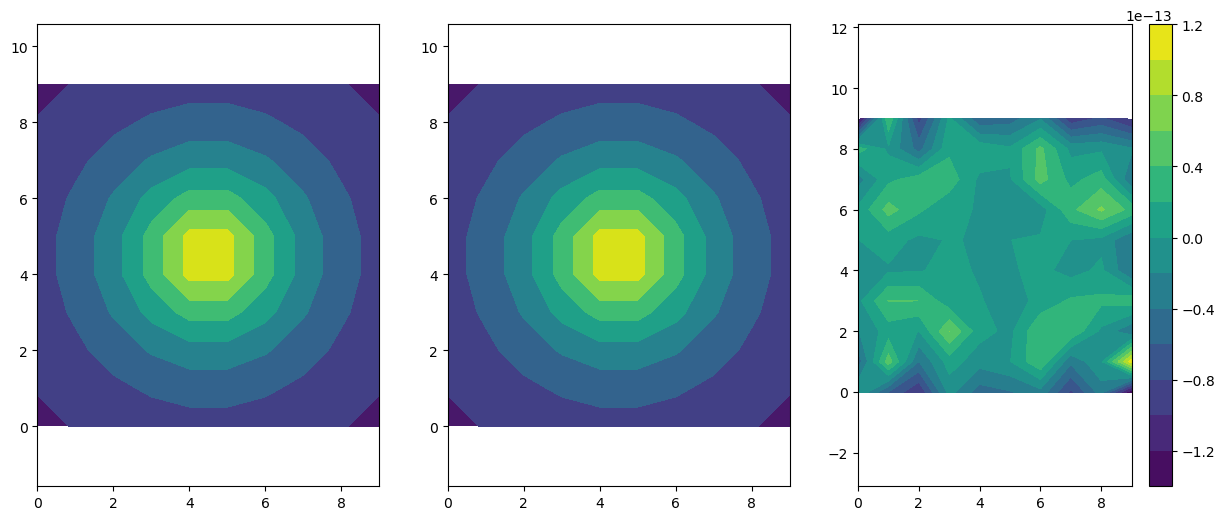

100%|██████████| 400/400 [00:38<00:00, 10.34it/s]


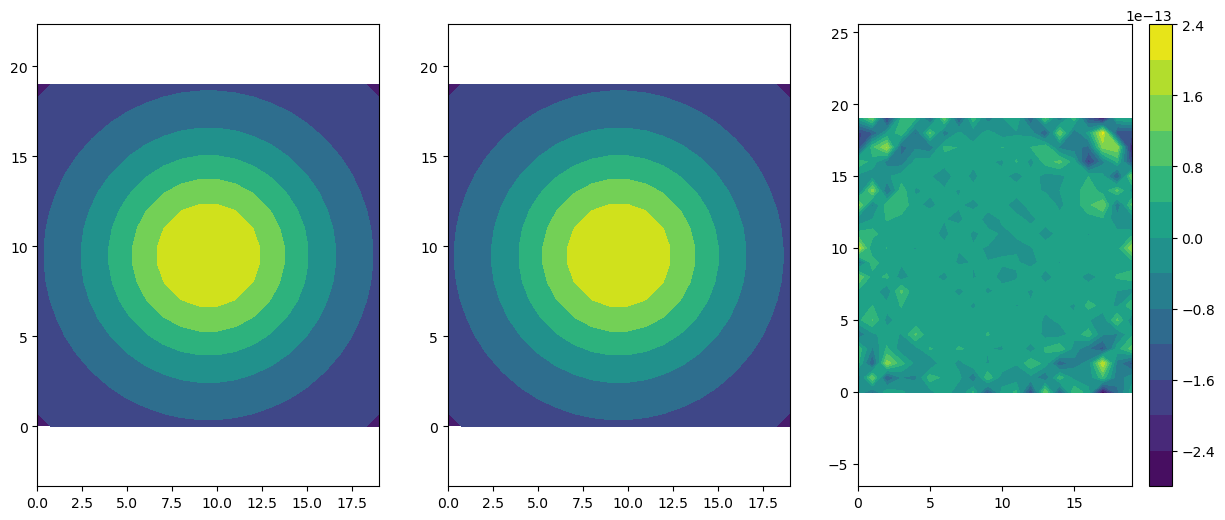

100%|██████████| 625/625 [01:28<00:00,  7.05it/s]


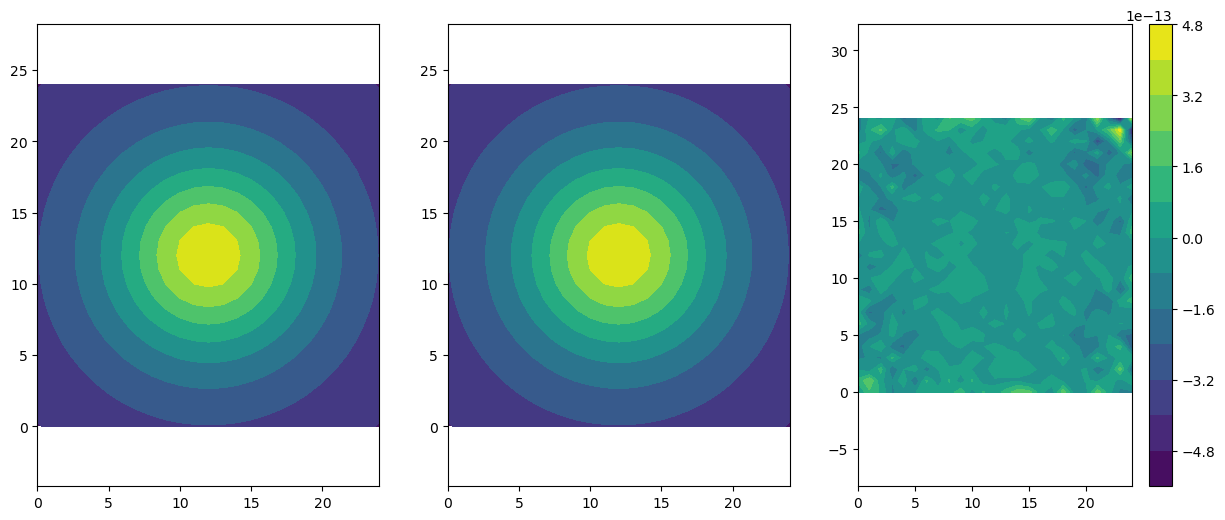

100%|██████████| 2500/2500 [21:49<00:00,  1.91it/s]


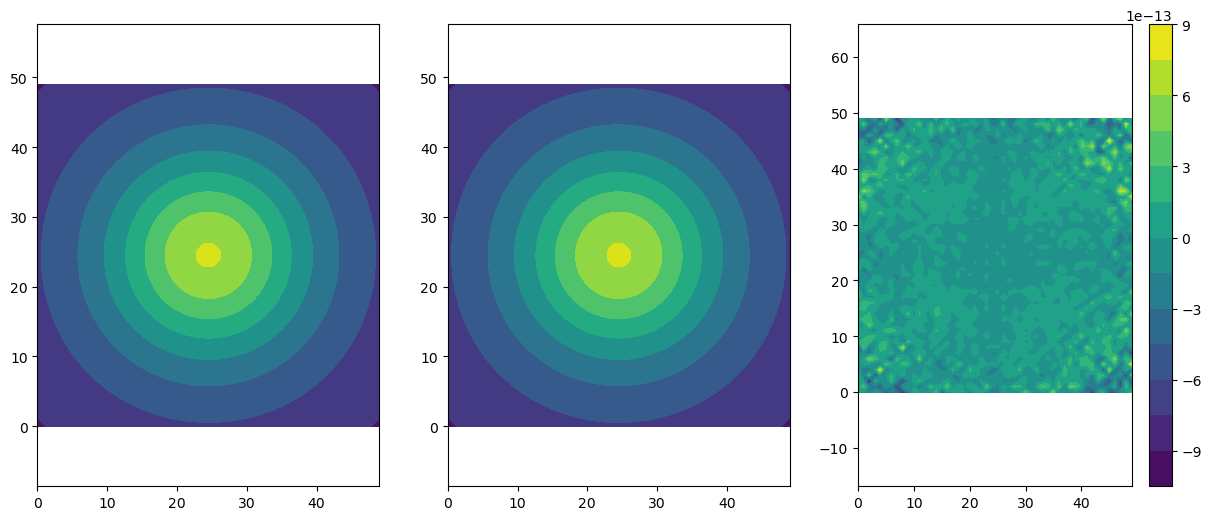

  0%|          | 8/10000 [00:29<10:03:56,  3.63s/it]


KeyboardInterrupt: 

In [114]:
nxs = [5, 10, 20, 25, 50, 100]
nys = [5, 10, 20, 25, 50, 100]
nzs = [2, 5,  7,  10, 25, 50]

xmax = 400
ymax = 400
zmax = 600


for nx, ny, nz in zip(nxs, nys, nzs):
    X = np.linspace(-xmax, xmax, nx)
    Y = np.linspace(-ymax, ymax, ny)
    Z = np.linspace(0, zmax, nz)

    XO = np.linspace(-xmax, xmax, nx)
    YO = np.linspace(-ymax, ymax, ny)

    dx = X[1] - X[0]
    dy = Y[1] - Y[0]
    dz = Z[1] - Z[0]

    zo = -5

    rho = np.ones((nx, ny, nz)) * 2.7

    XX, YY, ZZ = np.meshgrid(X, Y, Z)
    rho[np.sqrt(XX**2 + YY**2 + (ZZ - 300)**2) <= 200] = 500
    s = time.time()
    obs_fast = fast_forward()
    fast_time = time.time() - s

    s = time.time()
    obs_normal = multi_normal_forward()
    normal_time = time.time() - s

    plt.figure(figsize=(15, 6))
    plt.subplot(131)
    plt.contourf(obs_normal, levels=7)
    plt.axis('equal')

    plt.subplot(132)
    plt.contourf(obs_fast, levels=7)
    plt.axis('equal')

    plt.subplot(133)
    plt.contourf((obs_normal - obs_fast) / obs_normal, levels=12)
    plt.axis('equal')
    plt.colorbar()
    plt.show()

    sio.savemat("fast_{}|{}|{}_{}.mat".format(nx, ny, nz, fast_time), {'fast_data': obs_fast})
    sio.savemat("normal_{}|{}|{}_{}.mat".format(nx, ny, nz, normal_time), {'normal_data': obs_normal})

In [93]:
# data = sio.loadmat("./fast_50|50|25_1.6141138076782227.mat")['fast_data']
nx = 64
ny = 64
nz = 64

X = np.linspace(-xmax, xmax, nx)
Y = np.linspace(-ymax, ymax, ny)
Z = np.linspace(0, zmax, nz)

XO = np.linspace(-xmax, xmax, nx)
YO = np.linspace(-ymax, ymax, ny)

dx = X[1] - X[0]
dy = Y[1] - Y[0]
dz = Z[1] - Z[0]

zo = 5

rho = np.ones((nx, ny, nz))

XX, YY, ZZ = np.meshgrid(X, Y, Z)
rho[np.sqrt(XX**2 + YY**2 + (ZZ - 300)**2) <= 200] = 100

data = fast_forward()
# data = normal_forward()

100%|██████████| 64/64 [00:08<00:00,  7.48it/s]


(0.0, 63.0, 0.0, 63.0)

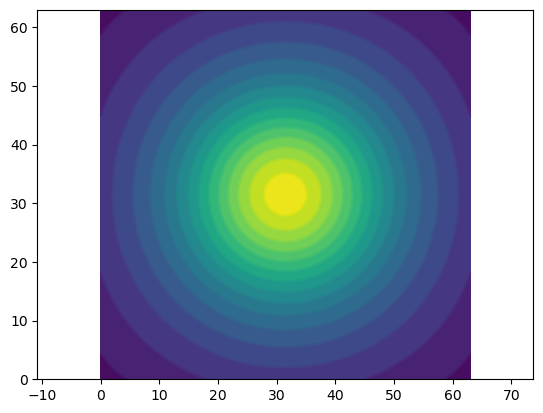

In [94]:
plt.contour(data, levels=15)
plt.contourf(data, levels=15)
plt.axis('equal')

***